# Hodoscope analysis

In [ ]:
!pip install uproot json5
!git clone https://github.com/jerenner/T9BeamTestAna.git
!cd T9BeamTestAna && git checkout t9_tb_2023

# Add T9BeamTestAna/python/new_analysis/hodoscope to PYTHONPATH
import sys
sys.path.append("T9BeamTestAna/python/new_analysis/hodoscope")

In [1]:
import sys
sys.path.append("/Users/jrenner/local/jerenner")

In [2]:
import os
import uproot
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms
from matplotlib.lines import Line2D

from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.signal import find_peaks

import T9BeamTestAna.python.new_analysis.hodoscope.hodoscope_functions_win as hd
import T9BeamTestAna.python.new_analysis.hodoscope.hodoscope_constants_win as hcw
chg_cuts_tight = hcw.chg_cuts_tight
chg_cuts_wide = hcw.chg_cuts_wide
chg_ranges_wide = hcw.chg_ranges_wide
timing_cuts_tight = hcw.timing_cuts_tight
timing_cuts_wide = hcw.timing_cuts_wide
timing_ranges_wide = hcw.timing_ranges_wide

# Define a Gaussian function with amplitude, mean, and standard deviation.
def gauss(x, amplitude, mean, stddev):
        return amplitude * norm.pdf(x, loc=mean, scale=stddev)
    
# Make a directory to store the figures.
if(not os.path.exists("fig")):
    os.mkdir("fig")

In [ ]:
# Download the dataset
!wget -O "hodoscope_data.tar.gz" "https://nubeusc-my.sharepoint.com/:u:/g/personal/jedward_renner_usc_es/EVOawbybrzdMmkbiyRDVN3MBjYIlzZnI0C9YVyXaPrsSbA?e=zZJisk&download=1"

In [ ]:
!tar -xvf hodoscope_data.tar.gz

# 1. Hodoscope run configuration

In [ ]:
# Hodoscope parameters
hodo_x_len = 4.2   # Length in x (transverse) direction (cm)
hodo_z_len = 2.0   # Length in z (downstream) direction (cm)
hodo_x_sep = 7.55  # Separation in x (transverse) direction (cm)
hodo_z_sep = 17.0  # Separation in z (downstream) direction (cm)

# Hodoscope positions from MC (x,z) in cm
hodoscope_positions = { 0: (86.9258, 183.884),
                        1: (87.5694, 202.285),
                        2: (79.411,  185.779),
                        3: (80.0546, 204.18),
                        4: (71.8963, 187.674),
                        5: (72.5398, 206.075),
                        6: (64.3815, 189.569),
                        7: (65.025, 207.97),
                        8: (56.8667, 191.464),
                        9: (57.5102, 209.865),
                       10: (49.3519, 193.359),
                       11: (49.9954, 211.76),
                       12: (41.8371, 195.253),
                       13: (42.4806, 213.655),
                       14: (34.3223, 197.148)}

# location of end of magnet in MC (in cm)
end_of_magnet_offset = 7.5

# Maximum length for showing positron path
l_max = 250

# Constants and field
c = 2.99792458e8
Bd = 0.23

### Beam configuration (*fig.beamconfig*)

In [ ]:
# Helper function to add a callout label
def add_callout_label(ax, point, end, label, labelsize, text_offset=(0,0)):
    ax.annotate(label,
                xy=point,
                xytext=end,
                arrowprops=dict(arrowstyle='-',linestyle='--',linewidth=0.5,facecolor='black'), # adjust line width and color
                fontsize=labelsize,
                fontweight='bold')

# Detectors to be placed on the drawing
detectors = [
    {'label': 'TOF0', 'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 15, 'lzoffset': 0, 'center': (0, -450.9), 'x_length': 10, 'z_length': .6, 'color': 'black'},
    {'label': 'ACT0', 'labelcallout': True, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 8, 'lzoffset': 0, 'center': (0, -112.9), 'x_length': 15, 'z_length': 15, 'color': 'gray'},
    {'label': 'ACT1', 'labelcallout': True, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 8, 'lzoffset': 0, 'center': (0, -92.9), 'x_length': 15, 'z_length': 15, 'color': 'gray'},
    {'label': 'TOF1', 'labelcallout': True, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 8, 'lzoffset': 0, 'center': (0, -80.1), 'x_length': 10, 'z_length': .6, 'color': 'black'},
    {'label': 'T2',   'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': -18, 'lzoffset': 0, 'center': (0, -56.9), 'x_length': 10, 'z_length': .6, 'color': 'black'},
    {'label': 'Magnet', 'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': -35, 'lzoffset': 0, 'center': (0, 0), 'x_length': 48, 'z_length': 15, 'color': 'red'},
    {'label': 'ACT3', 'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': -18, 'lzoffset': -5, 'center': (0, 295.1), 'x_length': 15, 'z_length': 15, 'color': 'gray'},
    {'label': 'Lead Glass', 'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 20, 'lzoffset': 5, 'center': (0, 332.35), 'x_length': 20.5, 'z_length': 49.5, 'color': 'green'}
]

zoffset = -450.9

fig, ax = plt.subplots(figsize=(16, 6))
fig.set_facecolor('white')

ax.set_xlim([-550-zoffset,400-zoffset])
ax.set_ylim([-70,95])

# Add gridlines
ax.grid(True, which='both', color='lightgray', alpha=0.4, linestyle='--')

# Add the detectors
for detector in detectors:
    y, x = detector['center']
    x_len, z_len = detector['x_length'], detector['z_length']
    rect = patches.Rectangle((x - z_len/2 - zoffset, y - x_len/2), z_len, x_len,
                             edgecolor='black', facecolor=detector['color'], alpha=0.8)
    ax.add_patch(rect)

    if(not detector['labelcallout']):
        ax.text(x+detector['lzoffset']-zoffset, y+detector['lxoffset'], detector['label'], ha='center',
                va='center', color='black', fontweight='bold', fontsize=detector['labelsize'], rotation=detector['labelrot'])

# Hodoscope label
ax.text(250-zoffset, 65, "Hodoscope", ha='center', va='center', color='black', fontweight='bold', fontsize=11)

# ACT0 callout label
point_ACT0 = (-112.9-zoffset, 6)
end_ACT0 = (-182.9-zoffset, 35)
add_callout_label(ax, point_ACT0, end_ACT0, "ACT0", detectors[1]['labelsize'], text_offset=(0,30))

# ACT1 callout label
point_ACT1 = (-92.9-zoffset, 6)
end_ACT1 = (-120-zoffset, 35)
add_callout_label(ax, point_ACT1, end_ACT1, "ACT1", detectors[2]['labelsize'], text_offset=(0,30))

# TOF1 callout label
point_TOF1 = (-80.1-zoffset,6)
end_TOF1 = (-60.1-zoffset,70)
add_callout_label(ax, point_TOF1, end_TOF1, "TOF1", detectors[3]['labelsize'], text_offset=(0,30))

# Beam annotation
ax.annotate("Beam", xy=(-10, 0), xytext=(-90, -3),
                arrowprops=dict(arrowstyle='->',facecolor='black'), # adjust line width and color
                fontsize=12,
                fontweight='bold')

# Add hodoscope elements and labels
labels_8 = [14, 12, 10, 8, 6, 4, 2, 0]
labels_7 = [13, 11, 9, 7, 5, 3, 1]

for i in range(8):  # First row

    # Create a rectangle patch
    draw_x = hodoscope_positions[labels_8[i]][1] - end_of_magnet_offset - hodo_z_len/2
    draw_y = hodoscope_positions[labels_8[i]][0] - hodo_x_len/2
    rectangle = patches.Rectangle((draw_x-zoffset, draw_y),
                                  hodo_z_len, hodo_x_len, facecolor='blue', alpha=1.0)
    ax.add_patch(rectangle)

    # Rotate the rectangle
    center_x = (draw_x-zoffset) + hodo_z_len/2
    center_y = draw_y + hodo_x_len/2
    rotation = transforms.Affine2D().rotate_deg_around(center_x, center_y, np.degrees(0.23))
    rectangle.set_transform(rotation + ax.transData)

for i in range(7):  # Second row

    # Create a rectangle patch
    draw_x = hodoscope_positions[labels_7[i]][1] - end_of_magnet_offset - hodo_z_len/2
    draw_y = hodoscope_positions[labels_7[i]][0] - hodo_x_len/2
    rectangle = patches.Rectangle((draw_x-zoffset, draw_y),
                                  hodo_z_len, hodo_x_len, facecolor='blue', alpha=1.0)
    ax.add_patch(rectangle)

    # Rotate the rectangle
    center_x = (draw_x-zoffset) + hodo_z_len/2
    center_y = draw_y + hodo_x_len/2
    rotation = transforms.Affine2D().rotate_deg_around(center_x, center_y, np.degrees(0.23))
    rectangle.set_transform(rotation + ax.transData)

# ------------------------------------------------------------------------------------------------------
# Plot the e+ and gamma tracks

# e+ along the beam
x_values = np.zeros(100)
z_values = np.linspace(-470, 7.5, 100)
ax.plot(z_values-zoffset, x_values, linestyle='--', linewidth=2, alpha=0.4, color='green')
ax.annotate("e$^{+}$", xy=(120, 10), xytext=(120, 10), fontsize=16, fontweight='bold', color='green')

# e+ after interaction in the magnet.
p_particle = 300
theta = Bd / (p_particle * 1e6 / c)  # calculate the angle at which the particle exits the magnetic field
z_values = np.linspace(0, l_max, 100)
dX_values = z_values * np.tan(theta)
ax.plot(z_values-zoffset+7.5, dX_values, linestyle='--', linewidth=2, alpha=0.4, color='green')

# gamma path
x_values = np.zeros(100)
z_values = np.linspace(-80.1, 330, 100)
ax.plot(z_values-zoffset, x_values, linestyle='--', linewidth=2, alpha=0.4, color='orange')
ax.annotate("$\gamma$", xy=(320, 10), xytext=(620, -20), fontsize=20, fontweight='bold', color='orange')

# ------------------------------------------------------------------------------------------------------

# Add a legend
#ax.legend(fontsize=13)

# Add labels and title
ax.set_xlabel('Downstream distance (cm)',fontsize=13.5)
ax.set_ylabel('Transverse distance (cm)',fontsize=13.5)
#ax.set_title('Approx. electron trajectories for different momenta',fontsize=18)

# Equal aspect ratio
ax.set_aspect('equal')

# Set larger tick marks
ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("fig/beamline.pdf", bbox_inches='tight')

### Calculation of energy that would hit each hodoscope element after bending (for use in *fig.LG_calibration*)
*Note that we assume all bending occurs at a single point located at the END of the magnet at the center of its aperture

In [ ]:
momenta_c = {} # momentum of electron hitting center of hodoscope element
momenta_l, momenta_r = {}, {} # momentum of electron hitting left and right of hodoscope element
momenta_delta = {} # momentum difference between left and right of hodoscope element
for elem, (x, z) in hodoscope_positions.items():

    z -= end_of_magnet_offset  # assume bending occurs just after end of magnet

    # Calculate the angle theta
    theta_c = np.arctan2(x, z)
    theta_l = np.arctan2(x+hodo_x_len/2, z)
    theta_r = np.arctan2(x-hodo_x_len/2, z)

    # Calculate the momentum in GeV/c
    p_c = Bd * c / theta_c / 1e9  # convert to GeV/c from kg*m/s
    p_l = Bd * c / theta_l / 1e9
    p_r = Bd * c / theta_r / 1e9

    # Store the calculations
    momenta_c[elem] = p_c
    momenta_l[elem] = p_l
    momenta_r[elem] = p_r
    momenta_delta[elem] = p_r - p_l

In [ ]:
# Electron momenta for hitting the center of each hodoscope element
momenta_c

In [ ]:
print("Approx. momentum range due to size of hodoscope elements:")
for elem in momenta_c.keys():
    p_deltac = momenta_delta[elem]/momenta_c[elem]
    print("-- Elem {}, range = {}, range/mean = {}".format(elem,momenta_delta[elem],p_deltac))

# 2. Plots of magnetic field map

In [ ]:
# Read the field map.
df = pd.read_csv('mfMapMeasured.txt', delim_whitespace=True, comment='%', header=None)

# Assign column names
df.columns = ['x', 'y', 'z', 'Bx', 'By', 'Bz']

# Compute the magnitude of the field
df['Bmag'] = np.sqrt(df['Bx']**2 + df['By']**2 + df['Bz']**2)

df.head(20)

#### 1D plot (*fig.fieldmap*)

In [ ]:
df_center = df[(df['y'] == 0) & (df['x'] == 0)]
df_r1 = df[(df['y'] == 0) & (df['x'] == 15.0)]

# Central axis
By_center = df_center['By'].values
z_center  = df_center['z'].values

# Off-axis near smallest bore edge
By_r1 = df_r1['By'].values
z_r1  = df_r1['z'].values

plt.figure(figsize=(8,5))
plt.plot(z_center,By_center,linewidth=1,color='black',label="B$_y$ (r = 0 mm)")
plt.plot(z_r1,By_r1,linewidth=1,color='black',linestyle='--',label="B$_y$ (r = 15 mm)")
plt.gca().tick_params(axis="x", labelsize=14)
plt.gca().tick_params(axis="y", labelsize=14)
plt.xlabel('Z (mm)',fontsize=14)
plt.ylabel('B$_{y}$ (T)',fontsize=14)
plt.legend(fontsize=17,loc=4)
plt.savefig("fig/Bfieldmap_axial.pdf")

# 3. Check of magnetic field
**Code adapted from D. Costas**

In [ ]:
runs  = [771, 772, 773, 774, 775, 776, 777, 778]
energies  = [0.18, 0.20, 0.22, 0.24, 0.26, 0.28, 0.30, 0.31]
means = []
stds  = []

# Loop over all runs and energies
for rnum, e in zip(runs, energies):

    df_dict = hd.read_dataframes_from_csv(f"ntuple_dataframes/win/run000{rnum}")

    debug = False

    # --------------------------------------------------------------------------------------------
    # Hodoscope elements
    # --------------------------------------------------------------------------------------------
    hd_dfs = {}

    # Create the filtered dataframes (containing peaks over the threshold at the correct time).
    for i in range(15):  # 0 to 14 inclusive
        hd_key = f'HD{i}'
        hit_col_name = f'hit_{hd_key}'
        hd_charge_range = chg_cuts_wide[hd_key]

        # Filtering
        #hd_filtered = filter_range(hd_key,df_dict[hd_key],'PeakTime',hd_time_range,debug=debug)
        hd_filtered = hd.filter_range(hd_key,df_dict[hd_key],'WindowIntPE',hd_charge_range,debug=debug)
        # hd_filtered = df_dict[hd_key][(df_dict[hd_key]['PeakTime'].between(*hd_time_range)) &
        #                         (df_dict[hd_key]['IntCharge'].between(*hd_charge_range))]
        if(debug): print(f"HD{i}: {len(hd_filtered)} of {len(df_dict[hd_key])} events after filter")

        # Assign a binary value indicating a hit
        if not hd_filtered.empty:
            hd_filtered.loc[:,hit_col_name] = 1
        else:
            hd_filtered.loc[:,hit_col_name] = 0

        hd_dfs[hd_key] = hd_filtered

    # Merge all HD dataframes
    combined_hd_df = hd_dfs['HD0'][['event', 'hit_HD0']]
    for i in range(1, 15):
        hd_key = f'HD{i}'
        hit_col_name = f'hit_{hd_key}'

        combined_hd_df = combined_hd_df.merge(
            hd_dfs[hd_key][['event', hit_col_name]],
            on='event',
            how='outer'
        ).fillna(0)

    # Calculate total number of hodoscope hits per event
    combined_hd_df['total_hits_HD'] = combined_hd_df.filter(like='hit_').sum(axis=1)

    # Only consider events with a single hodoscope element hit.
    hd_valid_events = combined_hd_df[combined_hd_df['total_hits_HD'] == 1]
    if(debug): print(f"Number of hd_valid_events = {len(hd_valid_events)}")

    u, c = np.unique(combined_hd_df['event'].values, return_counts=True)
    if(debug): print("Duplicates in combined HD dataframe:",np.sum(c[c > 1]))

    # --------------------------------------------------------------------------------------------
    # Fit the distribution of hit hodoscope elements to a Gaussian.
    # --------------------------------------------------------------------------------------------
    nHod    = 15
    counts  = []
    hods    = []
    for i in range(nHod):
        count = hd_valid_events["hit_HD{}".format(i)].values.sum()
        counts.append(count)
        hods.append(i)
        #print("HD{} Counts:".format(i), count)

    # Perform the fit.
    params, covariance = curve_fit(gauss, hods, counts, p0=[np.max(hods), np.mean(hods), 0.5])

    # Get the fit parameters.
    amplitude, mean, stddev = params
    means.append(mean)
    stds.append(stddev)

    # Create the fit curve to be overlain on the plot.
    x_smooth = np.linspace(min(hods), max(hods), 100)
    y_smooth = gauss(x_smooth, amplitude, mean, stddev)

    # Plot the histogram and fit curve.
    plt.bar(hods, counts)
    plt.plot(x_smooth, y_smooth, 'r-', label='Gaussian fit')
    plt.annotate('Average: {:.2f}'.format(mean), xy=(0.10, 0.85), xycoords='axes fraction')
    plt.annotate('Std: {:.2f}'.format(np.abs(stddev)), xy=(0.10, 0.80), xycoords='axes fraction')
    plt.annotate('Beam Momenta: {:.2f}'.format(e), xy=(0.60, 0.85), xycoords='axes fraction')

    plt.savefig('fig/bfield_check_hist_run_000{}.pdf'.format(rnum))
    plt.close()

In [ ]:
predicted_energy_calc  = np.array(list(momenta_c.values())) # from the calculation in section 1
predicted_energy_field = np.array([0.15158890334583247, 0.16500196241614948, 0.16689891285815453, 0.18098558047496965, 0.18444006152174303, 0.1998687822284445, 0.20793687667192717, 0.22493380116220932, 0.23657737755960637, 0.25659929028920303, 0.27549921662265936, 0.2976469225035761, 0.3282855128041124, 0.3533910011169222, 0.4060165450516617])
hod_element            = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

plt.plot(predicted_energy_calc*1000, hod_element, 'o-.', color='blue', label='Calculated Field (Lorentz Force)', alpha=0.7)
plt.plot(predicted_energy_field*1000, hod_element, '>-.', color='green', label='Monte Carlo w/Measured Field Map', alpha=0.7)
plt.errorbar(np.array(energies)*1000, means, np.abs(stds), fmt='.-', color='black', label='Beam Test Data', alpha=0.7)
plt.xlabel('Beam Momentum [MeV/c]',fontsize=14)
plt.ylabel('Hodoscope Element Hit',fontsize=14)
plt.legend(loc='lower right')
plt.savefig('fig/bfield_check.pdf'.format(rnum))

# 4. Gamma peak analysis

In [77]:
runs = [731, 732, 733, 734, 735, 736, 737, 738, 753, 754, 755, 756, 760, 763, 764, 765]
rmomenta = [460, 500, 600, 700, 800, 900, 1000, 1200, 500, 600, 700, 800, 1000, 900, 1200, 800]

ecal_m = 1.71e-2
ecal_b = 0.11

tof10_timing_range = [50,90]

## 4a. Multi-run analysis

In [78]:
# Run the gamma peak analysis for all runs.
all_fit_results, all_fit_arrays = [], []
all_ntot_evts, all_ntot_spills, all_ntot_tagged_evts = [], [], []
for rnum, pbeam in zip(runs, rmomenta):

    print("Processing run",rnum,"...")
    df_dict = hd.read_dataframes_from_csv(f"ntuple_dataframes/win/run000{rnum}")

    # Run the timing analysis (event selection).
    final_df, ntot_evts, ntot_spills, ntot_tagged_evts = hd.charge_timing_analysis_corrected_winInt(df_dict, tof10_timing_range, chg_cuts_wide, timing_cuts_wide)

    # Save the results of the gamma peak fits for plotting later.
    fit_results, fit_arrays = hd.gamma_peak_plots(final_df, rnum, pbeam, base_dir='plt/gamma_peaks', nbins=80, range=[0,20])

    all_fit_results.append(fit_results)
    all_fit_arrays.append(fit_arrays)
    all_ntot_evts.append(ntot_evts)
    all_ntot_spills.append(ntot_spills)
    all_ntot_tagged_evts.append(ntot_tagged_evts)

all_fit_results = np.array(all_fit_results)
all_fit_arrays = np.array(all_fit_arrays)

Processing run 731 ...


ValueError: cannot set a frame with no defined index and a scalar

In [74]:
print(len(final_df[final_df.total_hits_HD == 1]))
print(ntot_tagged_evts)

18890
18890


#### Summary of data (*tbl.data*)

In [ ]:
# Print table of results.
for rnum,p,nevts,nspills in zip(runs, rmomenta, all_ntot_evts, all_ntot_spills):
    print(f"{rnum} & {p} & {nevts} & {nspills} & \\\\")

In [ ]:
print("Percentage of events tagged:")
print(all_ntot_tagged_evts/np.array(all_ntot_evts))

#### Plot the number of tagged events per spill

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

all_ntot_spills = np.array(all_ntot_spills)
all_ntot_tagged_evts = np.array(all_ntot_tagged_evts)

ax.plot(rmomenta,all_ntot_tagged_evts/all_ntot_spills,'o',color='black')
ax.set_ylim([0,430])
ax.set_xlabel("Beam momentum (MeV/c)",fontsize=14)
ax.set_ylabel("Tagged photons/spill",fontsize=14)
plt.savefig("fig/tagged_evts_per_spill.pdf",bbox_inches='tight')

#### Lead glass calibration plot (*fig.LG_calibration*)

In [ ]:
# Plot all gamma peak means and fit lines on the same plot.
elec_hit_momenta_values = [v for v in hd.elec_hit_momenta_calc.values()]
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
momentum_color = {460: "red", 500: "orange", 600: "yellow", 700: "green",
                  800: "blue", 900: "violet", 1000: "gray", 1100: "brown", 1200: "black"}
momentum_plt   = {460: False, 500: False, 600: False, 700: False,
                  800: False, 900: False, 1000: False, 1100: False, 1200: False}

all_e_gamma_expected = []
for run_momentum, fit_array in zip(rmomenta,all_fit_arrays):

    # Get the fit means and errors for this run.
    fit_means, fit_smeans = fit_array[0], fit_array[1]

    # Apply the electron-based calibration
    fit_energy = [(mu - ecal_b)/ecal_m for mu in fit_means]
    fit_esigmas = [mu_e/ecal_m for mu_e in fit_smeans]

    # Compute the expected energies for each gamma.
    e_gamma_expected = [run_momentum - mval*1000 for mval in elec_hit_momenta_values[::-1]]
    all_e_gamma_expected.append(e_gamma_expected)

    if(not momentum_plt[run_momentum]):
        ax.errorbar(e_gamma_expected, fit_energy, yerr=fit_esigmas, fmt='.',
                    color=momentum_color[run_momentum], label=f"p = {run_momentum} MeV/c")
        momentum_plt[run_momentum] = True
    else:
        ax.errorbar(e_gamma_expected, fit_energy, yerr=fit_esigmas, fmt='.',
                    color=momentum_color[run_momentum])

# Fit a line to all results at once.
all_fit_means = (all_fit_arrays[:,0,:].flatten() - ecal_b)/ecal_m
all_fit_smeans = all_fit_arrays[:,1,:].flatten()/ecal_m
all_e_gamma_expected = np.array(all_e_gamma_expected).flatten()

p0 = [(np.max(all_e_gamma_expected) - np.min(all_e_gamma_expected))/(np.max(all_fit_means) - np.min(all_fit_means)),all_e_gamma_expected[0]]
popt, pcov = curve_fit(hd.line, all_e_gamma_expected, all_fit_means, p0, sigma=all_fit_smeans)
x = np.linspace(50, 1120, 1000)
y = hd.line(x, *popt)
perr = np.sqrt(np.diag(pcov))
#ax.plot(x, y, label='C = $({:.2f} \pm {:.2f}) x 10^{{-4}} \cdot $p + $({:.3f} \pm {:.4f})$'.format(popt[0]*10000,perr[0]*10000,popt[1],perr[1]), color='red', alpha=0.8, linewidth=3, linestyle=':')
ax.plot(x, y, color='black', alpha=0.8, linewidth=1, linestyle='-')
#ax.annotate("---- C = $({:.4f} \pm {:.4f}) x 10^{{-2}} \cdot $E + $({:.3f} \pm {:.4f})$".format(popt[0]*100,perr[0]*100,popt[1],perr[1]), xy=(500, 0.10), xytext=(200, 0.01), fontsize=13, fontweight='bold', color='black')
ax.annotate("---- $({:.4f} \pm {:.4f}) \cdot $E + $({:.3f} \pm {:.4f})$".format(popt[0],perr[0],popt[1],perr[1]), xy=(500, 100), xytext=(150, 100), fontsize=13, fontweight='bold', color='black')

ax.legend(title="Beam momentum",title_fontsize=12,fontsize=11)
ax.set_ylabel('Lead glass measured energy [MeV]',fontsize=14)
ax.set_xlabel('Expected photon energy [MeV]',fontsize=14)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
plt.savefig("fig/LG_calibration.pdf", bbox_inches='tight')

In [ ]:
# Plot the slope and intercept of each calibration curve vs. momentum.
mvals = all_fit_results[:,0]
merr = all_fit_results[:,1]
bvals = all_fit_results[:,2]
berr = all_fit_results[:,3]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
flat_axes = axes.ravel()

flat_axes[0].errorbar(rmomenta,mvals,yerr=merr,fmt='o')
flat_axes[0].set_xlabel('Beam momentum (MeV/c)',fontsize=20)
flat_axes[0].set_ylabel('Slope',fontsize=20)
flat_axes[0].tick_params(axis="x", labelsize=14)
flat_axes[0].tick_params(axis="y", labelsize=14)

flat_axes[1].errorbar(rmomenta,bvals,yerr=berr,fmt='o')
flat_axes[1].set_xlabel('Beam momentum (MeV/c)',fontsize=20)
flat_axes[1].set_ylabel('Intercept (LG WindowIntPE)',fontsize=20)
flat_axes[1].tick_params(axis="x", labelsize=14)
flat_axes[1].tick_params(axis="y", labelsize=14)

## 4b. Single-run analysis

In [43]:
# Reload charge cuts if necessary for debugging.
def reload_constants():
    import importlib
    importlib.reload(hcw)
    global chg_cuts_tight, chg_cuts_wide, chg_ranges_wide
    chg_cuts_tight = hcw.chg_cuts_tight
    chg_cuts_wide = hcw.chg_cuts_wide
    chg_ranges_wide = hcw.chg_ranges_wide
    timing_cuts_tight = hcw.timing_cuts_tight
    timing_cuts_wide = hcw.timing_cuts_wide
    timing_ranges_wide = hcw.timing_ranges_wide

In [44]:
# Read in all dataframes from a given run
rnum = 735
low_radiation = False
pbeam = 800
tail_threshold = 2.6
df_dict = hd.read_dataframes_from_csv(f"ntuple_dataframes/merged/run000{rnum}")
df_dict.keys()

dict_keys(['ACT0L', 'ACT1L', 'ACT3R', 'TOF01', 'HD3', 'HD11', 'HD10', 'HD2', 'TOF00', 'HD0', 'TOF02', 'HD12', 'HD13', 'TOF03', 'HD1', 'TOF13', 'HD5', 'PbGlass', 'TOF12', 'HD4', 'HD6', 'TOF10', 'HD14', 'HD7', 'TOF11', 'HD9', 'HD8', 'TriggerScint', 'ACT0R', 'ACT1R', 'ACT3L'])

Examine the charge for each detector. Here we will be placing "wide" cuts which encompass the entire range of sensible charge values for each detector.

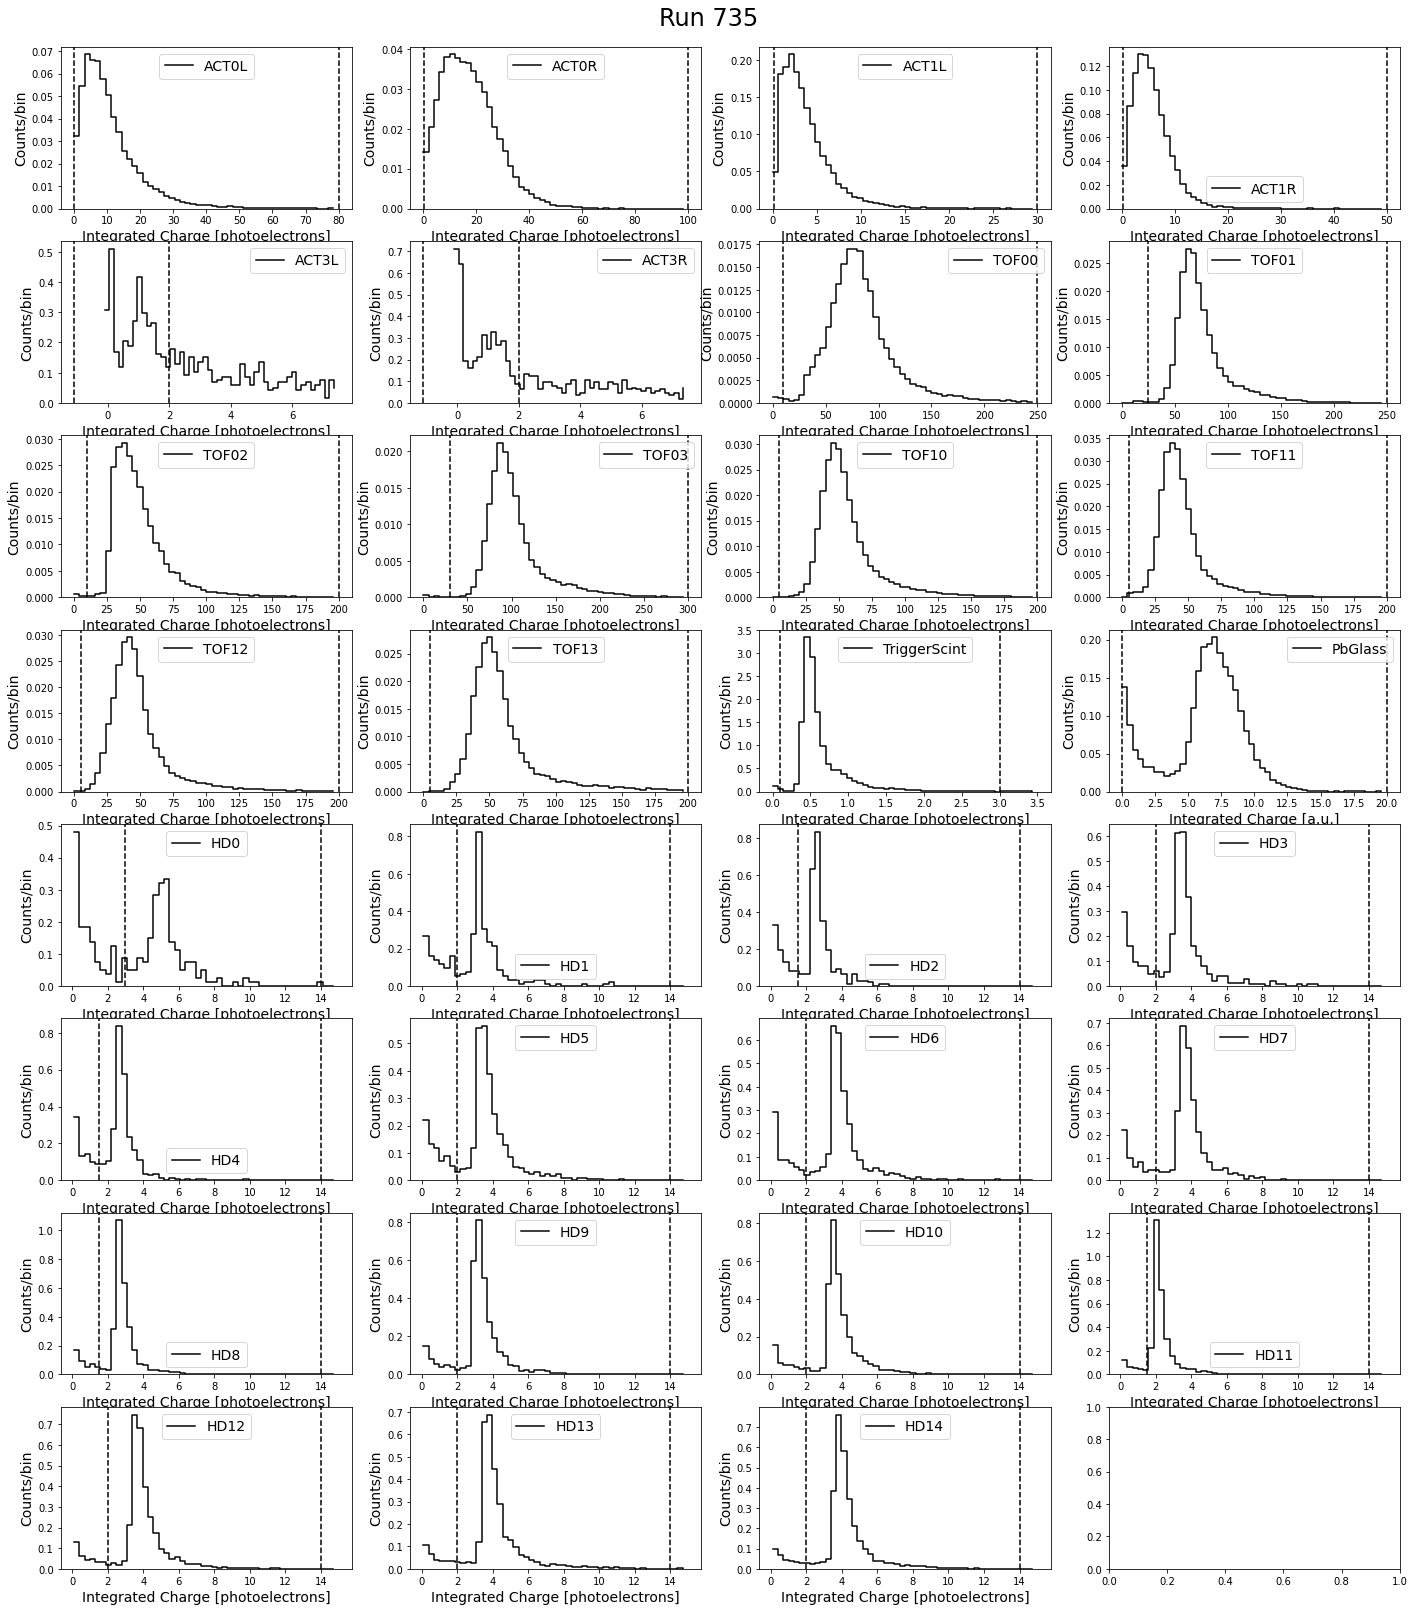

In [45]:
# Reload charge cuts if necessary.
reload_constants()

# Assign the charge cuts
chg_cuts = chg_cuts_wide
chg_range = chg_ranges_wide

hd.plot_charge_histograms(df_dict, 'WindowIntPE', chg_cuts, chg_range, rnum, nbins = 50, evt_list = None, lbl = '', evt_list_2 = None, lbl_2 = 'all', select_nonzero_peaks = True, normed = True, logscale = False, plt_hist='all')

Examine the timing for each detector, again with "wide" cuts

Initial params: [3547, 73.55474729853411, 10.494343923620281]


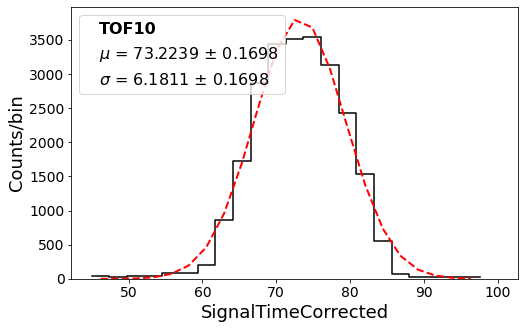

In [46]:
# Make timing plots for all detectors using the SignalTimeCorrected branch
# Consider the time for all detectors relative to TOF10
pk_times = df_dict['TOF10']['SignalTimeCorrected']
t_range = [45,100]
nbins = 23
normed = False
hd.timing_plot('TOF10',pk_times,t_range,nbins)

In [47]:
# Cut on events with peaks in TOF10 at the selected values
#df_T1sel = hd.filter_range('TOF10',df_dict['TOF10'],'SignalTimeCorrected',[50,90],drop=True,debug=True)
# Set the TOF10 timing range based on the above plot.
tof10_timing_range = [50,90]

TOF10 filter passed 24176 of 24982 with 294 duplicates
--> returning 23882 events


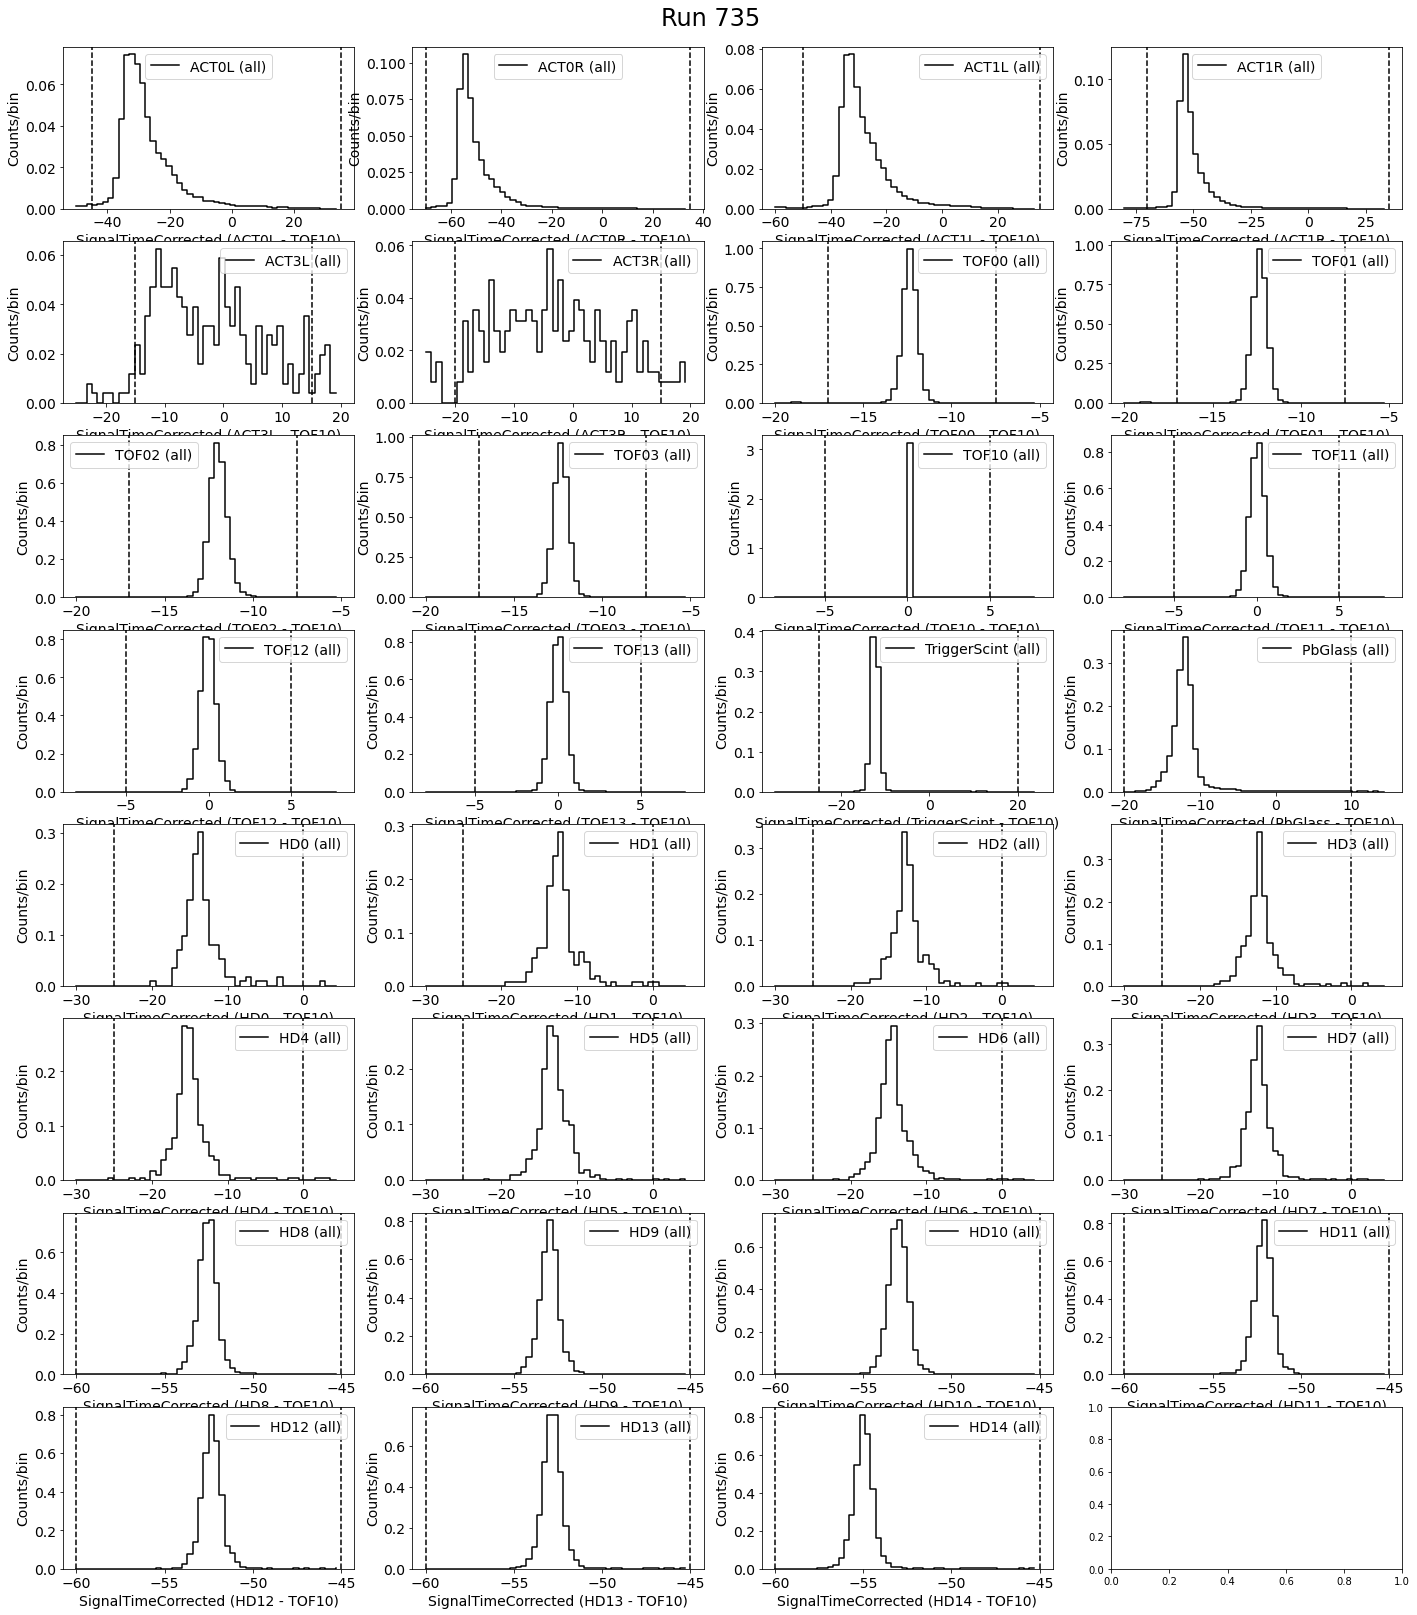

In [48]:
# Reload timing cuts if necessary.
reload_constants()

# Assign the charge cuts
timing_cuts = timing_cuts_wide
timing_range = timing_ranges_wide

hd.plot_timing_histograms(df_dict, tof10_timing_range, chg_cuts_wide, timing_cuts, timing_range, rnum, nbins = 50, evt_list = None, lbl = 'all', evt_list_2 = None, lbl_2 = 'all', select_nonzero_peaks = True, normed = True, logscale = False, plt_hist='all')

##### Apply the charge and timing cuts
Here we create a dataframe `final_df` containing the events that passed the wide charge cuts. The function `charge_timing_analysis_corrected_winInt` returns a dataframe containing all lead glass peaks (for events containing 1 peak only) and a `hit_` column for each detector specifying whether the charge cuts were met (= 1) or not (= 0).

In [49]:
final_df, ntot_evts, ntot_spills, ntot_tagged_evts = hd.charge_timing_analysis_corrected_winInt(df_dict, tof10_timing_range, chg_cuts_wide, timing_cuts_wide)

/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


#### Gamma peaks plot (*fig.gamma_peaks*)

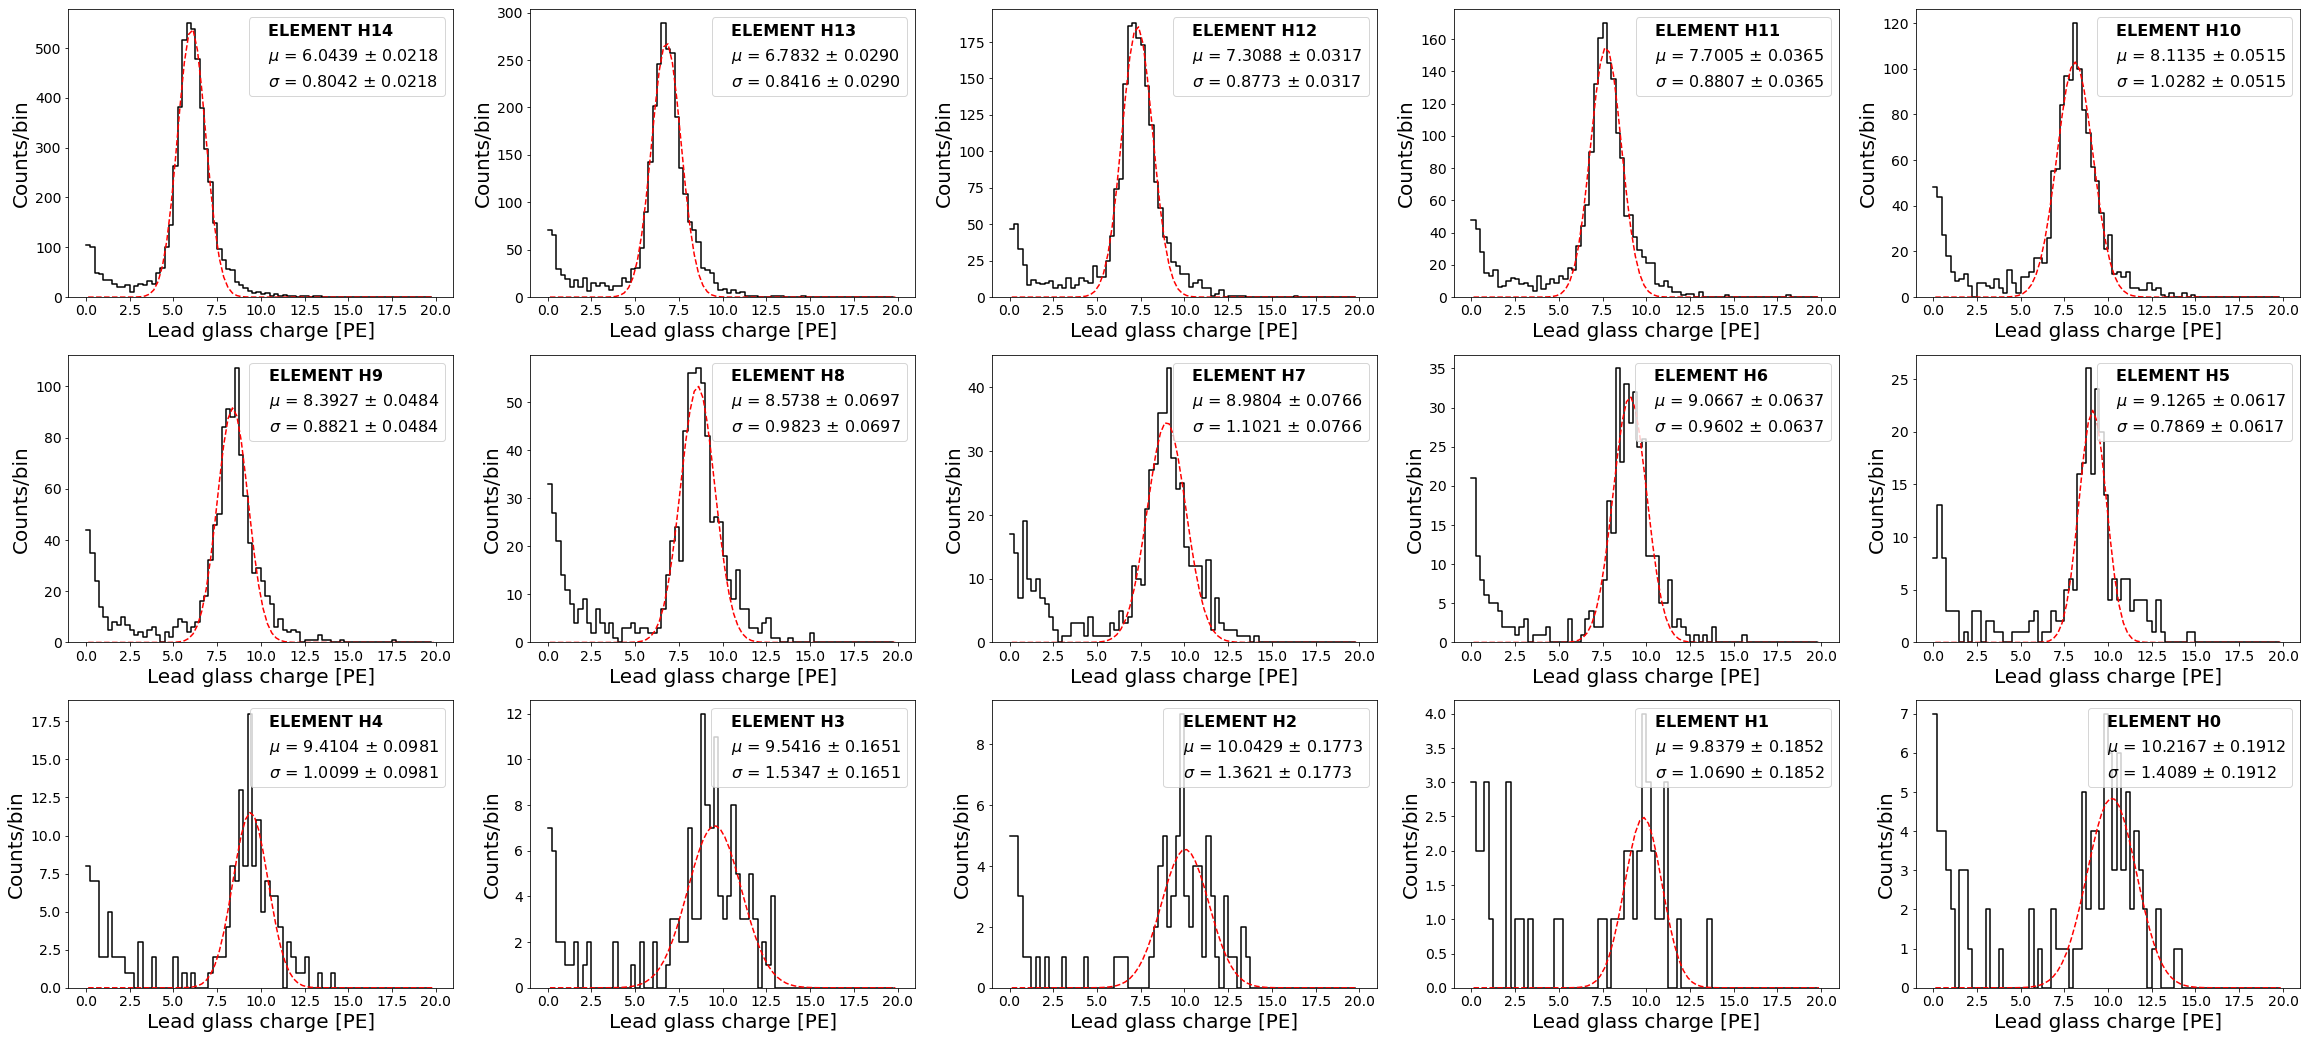

In [50]:
fit_results, fit_arrays = hd.gamma_peak_plots(final_df, rnum, pbeam, base_dir='fig/gamma_peaks', nbins=80, range=[0,20], timing_cuts=False, low_radiation=False)

#### HD14 gamma peak (*fig.gamma_peak_H14*)

In [51]:
def gauss(x, amplitude, mean, stddev):
        return amplitude * norm.pdf(x, loc=mean, scale=stddev)

Uncalibrated histogram

Initial params: [459, 5.738399749033201, 1.8556330851990561]
Calculated tail threshold = 2.6


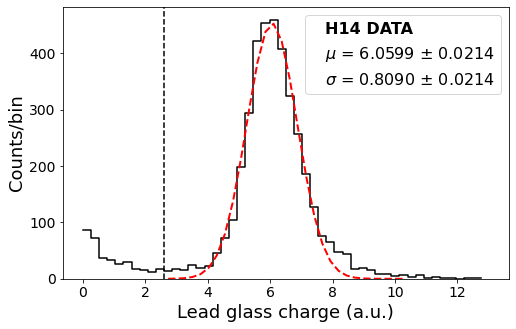

In [70]:
hd.plot_HD14_peak(final_df, e_range = [0, 13], ecal_m = 1.0, ecal_b = 0.0, nbins = 50, fit_start = 10, fit_end = 40, normed = False, tail_threshold = tail_threshold, energy_cut = 0, low_radiation = False)

Calibrated histogram

Initial params: [460, 346.8247749770557, 81.16398203005419]
Calculated tail threshold = 145.61403508771932


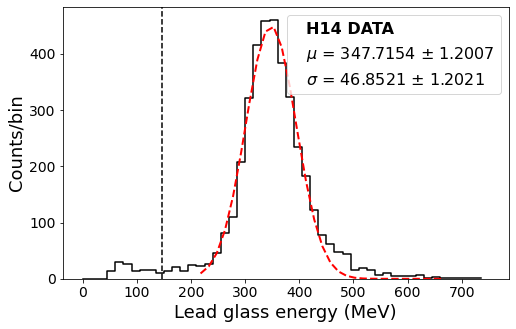

In [79]:
hd.plot_HD14_peak(final_df, e_range = [0, 750], ecal_m = ecal_m, ecal_b = ecal_b, nbins = 50, fit_start = 14, fit_end = 45, normed = False, tail_threshold = tail_threshold, energy_cut = 50, low_radiation = False)

### Look at multi-element hits

Initial params: [5, 3.7899604655037145, 3.4811212331128067]
Calculated tail threshold = 2.6


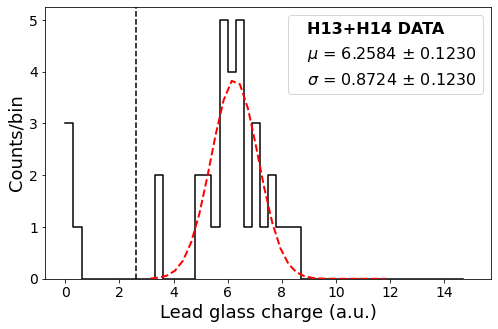

In [57]:
e_range = [0, 15]
ecal_m = 1.0
ecal_b = 0.0
nbins = 50
fit_start = 10
fit_end = 40
normed = False
energy_cut = 0
low_radiation = False

cuts_nominal = (final_df.hit_HD14 == 1) & (final_df.hit_HD13 == 1) & (final_df.total_hits_HD == 2) & (final_df.LG_nWindowPeaks == 1)
cuts_charge = (final_df.hit_ACT0 == 1) & (final_df.hit_ACT1 == 1) & (final_df.hit_TOF0 == 1) & (final_df.hit_TOF1 == 1) & (final_df.hit_T2 == 1) & (final_df.nohit_ACT3 == 1)

lg_energy = (final_df[cuts_nominal & cuts_charge]['LG_WindowIntPE'] - ecal_b) / ecal_m

# Create the plot
hist, bin_edges = np.histogram(lg_energy, bins=nbins, range=e_range, density=normed)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Gaussian fit
initial_params = [np.max(hist), np.mean(lg_energy), np.std(lg_energy)]
print(f"Initial params: {initial_params}")
popt, pcov = curve_fit(gauss, bin_centers[fit_start:fit_end], hist[fit_start:fit_end], p0=initial_params)
perr = np.sqrt(np.diag(pcov))
fit_curve = gauss(bin_centers[fit_start:fit_end], *popt)

# Plot the fit peak
fig = plt.figure(figsize=(8,5))
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges)[0], align='edge', color='white')
plt.plot(bin_edges[:-1], hist, color='black', drawstyle='steps-post')
plt.plot(bin_centers[fit_start:fit_end], fit_curve, '--', color='red', linewidth=2.0, alpha=1.0)

# Plot the tail threshold
tail_threshold_energy = (tail_threshold - ecal_b)/ecal_m
plt.axvline(tail_threshold_energy,color='black',linestyle='--')
print(f"Calculated tail threshold = {tail_threshold_energy}")

# Prepare the legend.
lbl1 = f"H13+H14 DATA"
lbl2 = "$\mu$ = {:.4f} $\pm$ {:.4f}".format(popt[1],perr[1])
lbl3 = "$\sigma$ = {:.4f} $\pm$ {:.4f}".format(popt[2],perr[2])
legend_elements = [Line2D([0], [0], color='none', lw=0, label=lbl1),
                Line2D([0], [0], color='none', lw=0, label=lbl2),
                Line2D([0], [0], color='none', lw=0, label=lbl3)]
leg = plt.legend(handles=legend_elements, frameon=True, handlelength=0, fontsize=16)
for i, text in enumerate(leg.get_texts()):
    if i == 0:
        text.set_weight('bold')
    text.set_horizontalalignment('right')

if(ecal_b == 0.0 and ecal_m == 1.0):
    plt.xlabel("Lead glass charge (a.u.)",fontsize=18)
else:
    plt.xlabel("Lead glass energy (MeV)",fontsize=18)
plt.ylabel("Counts/bin",fontsize=18)
plt.gca().tick_params(axis="x", labelsize=14)
plt.gca().tick_params(axis="y", labelsize=14)

### Application of additional charge cuts

In [58]:
df_widecuts, _, _, _ = hd.charge_timing_analysis_corrected_winInt(df_dict, tof10_timing_range, chg_cuts_wide, timing_cuts_wide)

/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [59]:
# Select HD14 peak and tail events
cuts_hd14      = (df_widecuts.hit_HD14 == 1)
cuts_hd14_peak = cuts_hd14 & (df_widecuts.LG_WindowIntPE >= tail_threshold)
cuts_hd14_tail = cuts_hd14 & (df_widecuts.LG_WindowIntPE <  tail_threshold) # & (final_df.LG_WindowIntPE > 1.0)

# Get the list of peak events.
df_peak = df_widecuts[cuts_hd14_peak]
evt_list_PEAK = np.array(df_peak.event.values)

# Get the list of tail events.
df_tail = df_widecuts[cuts_hd14_tail]
evt_list_TAIL = np.array(df_tail.event.values)

print(f"{len(evt_list_PEAK)} peak events and {len(evt_list_TAIL)} tail events")

4754 peak events and 1086 tail events


Now we remake the charge plots showing the normalized distributions of peak (>= tail_threshold) and tail (< tail_threshold) events.

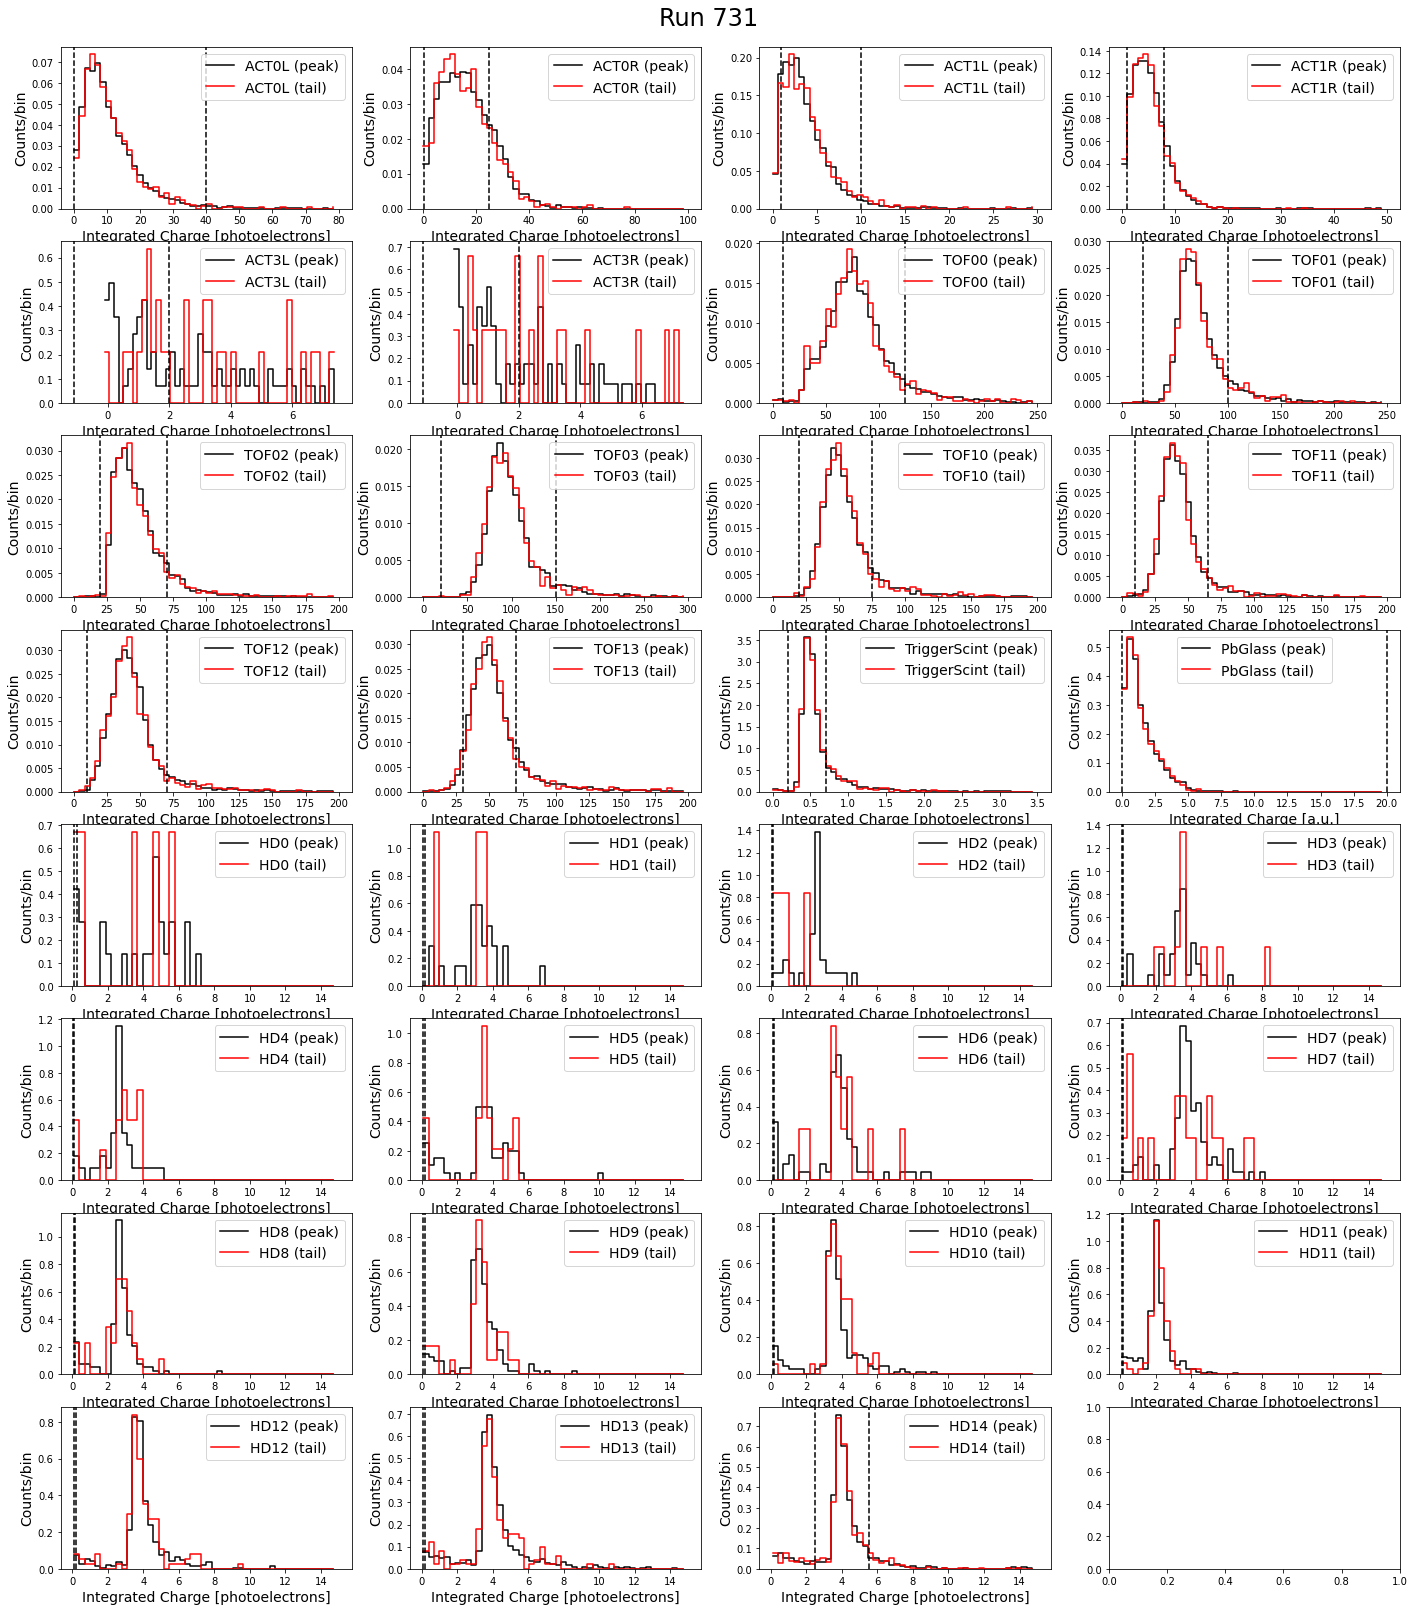

In [80]:
# Reload charge cuts if necessary.
reload_constants()

# Assign the charge cuts
chg_cuts = chg_cuts_tight
chg_range = chg_ranges_wide

hd.plot_charge_histograms(df_dict, 'WindowIntPE', chg_cuts, chg_range, rnum, nbins = 50, evt_list = evt_list_PEAK, lbl = 'peak', evt_list_2 = evt_list_TAIL, lbl_2 = 'tail', select_nonzero_peaks = True, normed = True, logscale = False, plt_hist='all')

And the similar timing plots

TOF10 filter passed 24176 of 24982 with 294 duplicates
--> returning 23882 events


/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


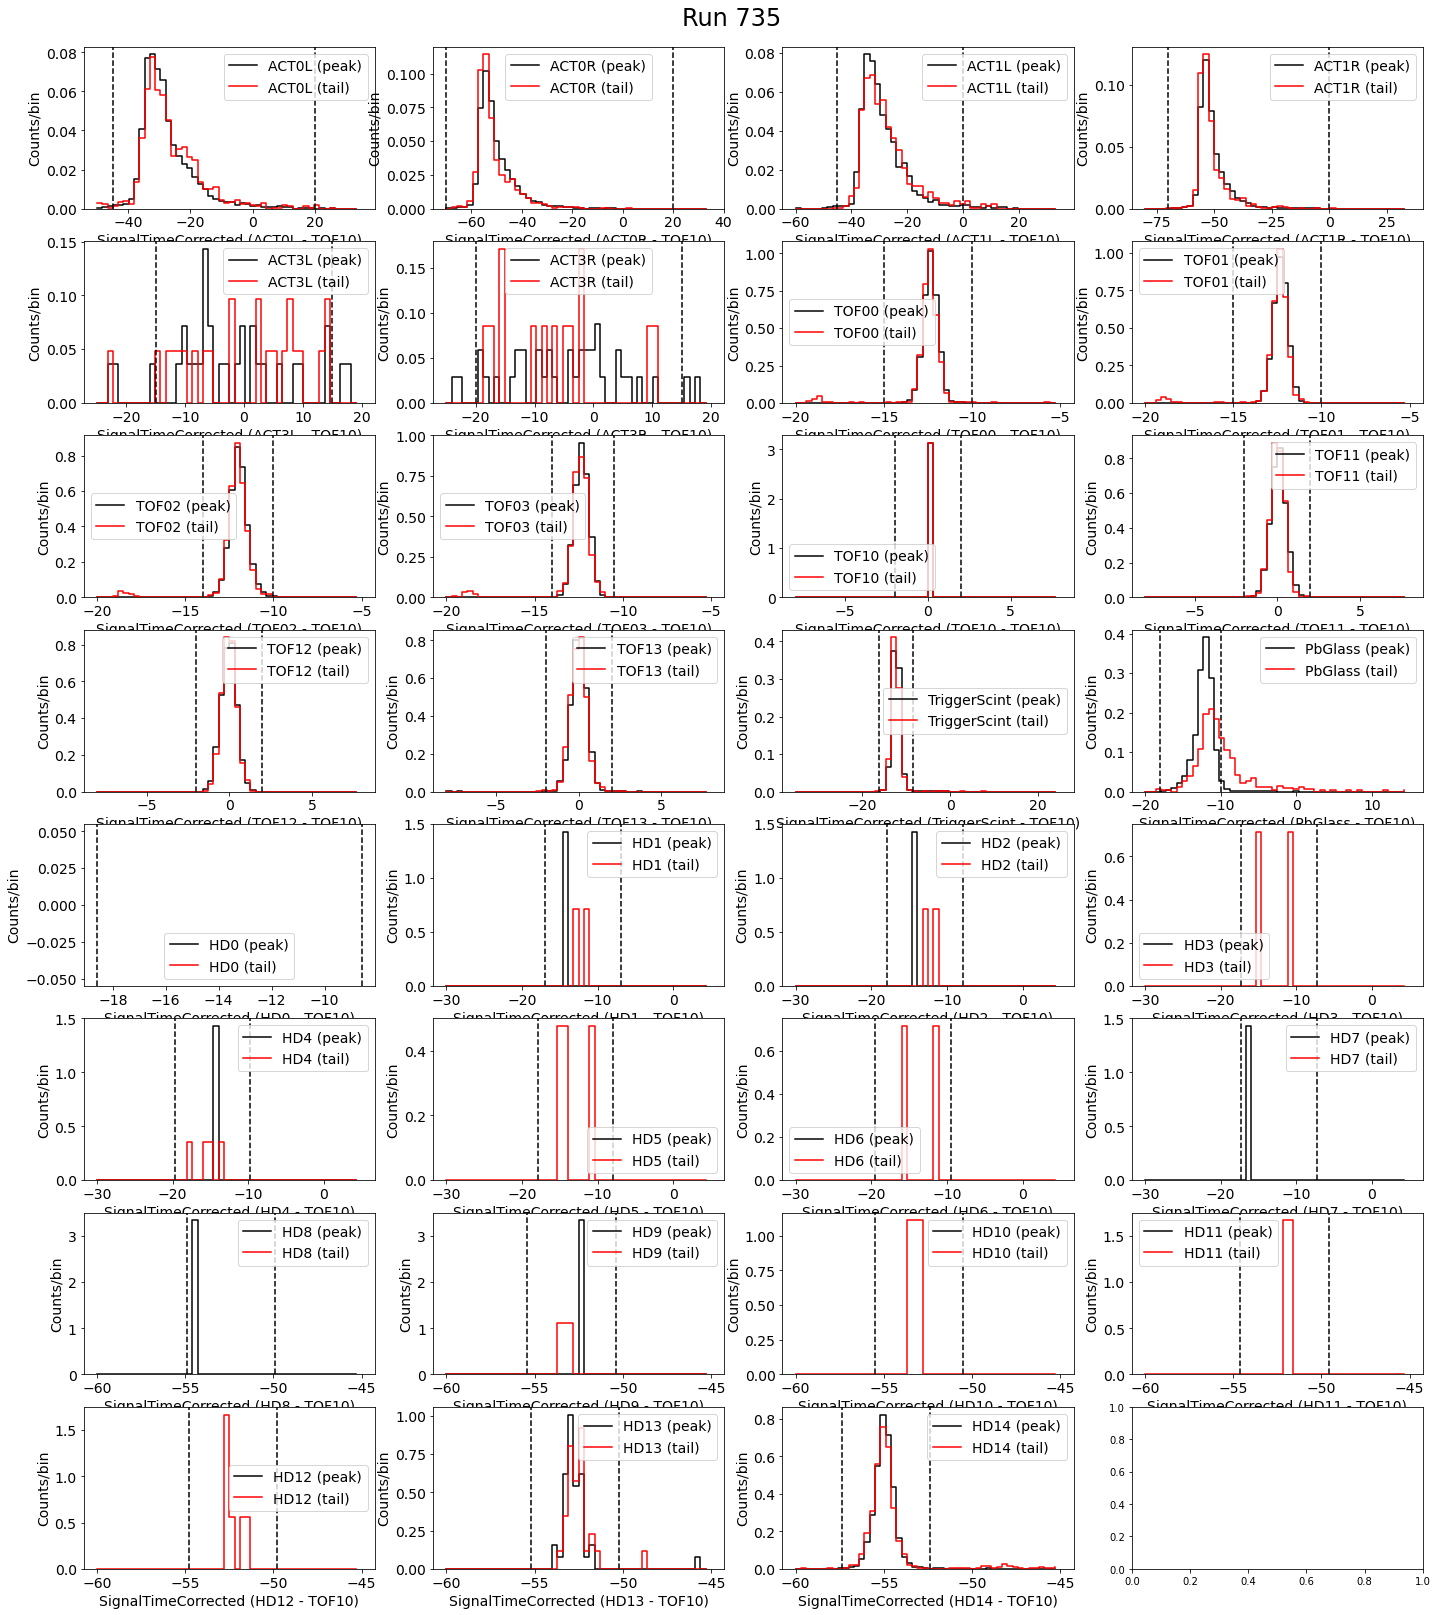

In [61]:
# Reload timing cuts if necessary.
reload_constants()

# Assign the charge cuts
timing_cuts = timing_cuts_tight
timing_range = timing_ranges_wide

hd.plot_timing_histograms(df_dict, tof10_timing_range, chg_cuts_wide, timing_cuts, timing_range, rnum, nbins = 50, evt_list = evt_list_PEAK, lbl = 'peak', evt_list_2 = evt_list_TAIL, lbl_2 = 'tail', select_nonzero_peaks = True, normed = True, logscale = False, plt_hist='all')

In [62]:
df_tightcuts, _, _, _ = hd.charge_timing_analysis_corrected_winInt(df_dict, tof10_timing_range, chg_cuts_wide, timing_cuts_wide)

/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


### Charge cut table (*tbl.timingcuts*)

In [63]:
# Print timing cut table
print(f"Tail threshold is {tail_threshold}")
cuts_hd14      = (df_tightcuts.hit_HD14 == 1)
cuts_hd14_tail = cuts_hd14 & (df_tightcuts.LG_WindowIntPE <  tail_threshold) #& (final_df.LG_WindowIntPE > 1.0)
cuts_hd14_peak = cuts_hd14 & (df_tightcuts.LG_WindowIntPE >= tail_threshold)

# Total numbers of events
tot_hd14 = len(df_tightcuts[cuts_hd14])
tot_hd14_peak = len(df_tightcuts[cuts_hd14_peak])
tot_hd14_tail = len(df_tightcuts[cuts_hd14_tail])

# Cuts to evaluate
cuts_ACT0      = (df_tightcuts.hit_ACT0 == 1)
cuts_ACT1      = (df_tightcuts.hit_ACT1 == 1)
cuts_ACT3      = (df_tightcuts.nohit_ACT3 == 1)
cuts_TOF0      = (df_tightcuts.hit_TOF0 == 1)
cuts_TOF1      = (df_tightcuts.hit_TOF1 == 1)
cuts_T2        = (df_tightcuts.hit_T2 == 1)
cuts_all       = cuts_ACT0 & cuts_ACT1 & cuts_TOF0 & cuts_TOF1 & cuts_T2 & cuts_ACT3

# Arrays for iterating through the cuts
cuts_txt = ["HD14 hit only", "ACT0 hit", "ACT1 hit", "ACT3 no hit", "TOF0 hit", "TOF1 hit", "T2 hit", "All"]
cuts_arr = [cuts_hd14, cuts_ACT0, cuts_ACT1, cuts_ACT3, cuts_TOF0, cuts_TOF1, cuts_T2, cuts_all]

print("Cut & All evts (\\%) & Peak evts (\\%) & Tail evts (\\%)\\\\")
print("\hline")
for txt,cuts in zip(cuts_txt,cuts_arr):
    nall  = len(df_tightcuts[cuts_hd14 & cuts])
    npeak = len(df_tightcuts[cuts_hd14_peak & cuts])
    ntail = len(df_tightcuts[cuts_hd14_tail & cuts])

    print(f"{txt} & {nall} ({nall/tot_hd14*100:.0f}) & {npeak} ({npeak/tot_hd14_peak*100:.0f}) & {ntail} ({ntail/tot_hd14_tail*100:.0f})\\\\")

Tail threshold is 2.6
Cut & All evts (\%) & Peak evts (\%) & Tail evts (\%)\\
\hline
HD14 hit only & 5840 (100) & 4754 (100) & 1086 (100)\\
ACT0 hit & 5563 (95) & 4547 (96) & 1016 (94)\\
ACT1 hit & 5147 (88) & 4263 (90) & 884 (81)\\
ACT3 no hit & 5559 (95) & 4537 (95) & 1022 (94)\\
TOF0 hit & 5713 (98) & 4688 (99) & 1025 (94)\\
TOF1 hit & 5819 (100) & 4741 (100) & 1078 (99)\\
T2 hit & 5830 (100) & 4751 (100) & 1079 (99)\\
All & 4591 (79) & 3838 (81) & 753 (69)\\


Initial params: [429, 346.8247749770557, 81.16398203005419]
Calculated tail threshold = 145.61403508771932


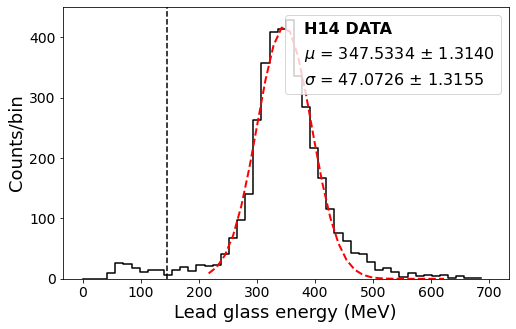

In [67]:
hd.plot_HD14_peak(df_tightcuts, e_range = [0, 700], ecal_m = ecal_m, ecal_b = ecal_b, nbins = 50, fit_start = 15, fit_end = 45, normed = False, tail_threshold = tail_threshold, energy_cut = 50, low_radiation = False)

## 4c. Waveform analysis (*fig.waveform*)

In [23]:
import json5
import T9BeamTestAna.python.new_analysis.waveform_analysis as wf

In [24]:
# Open the run file and config file.
run_file = uproot.open("root_run_000735.root")
config = json5.load(open("/Users/jrenner/local/jerenner/T9BeamTestAna/config/config_hodoscope.json"))['WaveAnalysis']

# Load the waveforms for HD14.
waveforms_HD14 = run_file['midas_data_D302']['Channel7'].array().to_numpy()

# Run the analysis of the waveforms.
analysis = wf.WaveformAnalysis(waveforms_HD14,
                            threshold=config["Thresholds"][0],
                            analysis_window=(config["AnalysisWindowLow"][0], config["AnalysisWindowHigh"][0]),
                            pedestal_window=(config["PedestalWindowLow"][0], config["PedestalWindowHigh"][0]),
                            reverse_polarity=(config["Polarity"][0]==0),
                            voltage_scale=config["VoltageScale"],
                            time_offset=config["TimeOffset"][0])
analysis.find_all_peak_voltages()

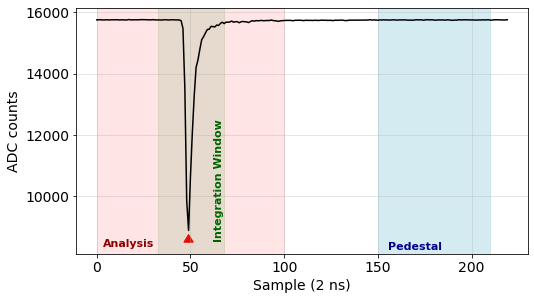

In [40]:
evt = 20673
base_dir = "fig"

# Get the integration window for the selected event.
df_hd14 = df_dict['HD14']
win_lower_times = df_hd14[df_hd14.event == evt]['WindowLowerTime'].values
win_upper_times = df_hd14[df_hd14.event == evt]['WindowUpperTime'].values

fig, axs = plt.subplots(1, 1, figsize=(7,4))
fig.tight_layout()
axs.plot(waveforms_HD14[evt][0:220],color='black')

# Iterate over peak times and plot arrows
for peak in analysis.pulse_peak_times[evt]:

    # Divide out the 2 ns / sample.
    peak_sample = int(peak/2)

    # Get the corresponding ADC count for the peak time
    y_peak = waveforms_HD14[evt][int(peak/2)]

    # Plot the arrow. The -5 in dy is arbitrary and used to offset the arrow tip for visibility.
    axs.arrow(peak_sample, y_peak-400, 0, 15, head_width=5, head_length=250, fc='red', ec='red')

axs.grid(alpha=0.4)
axs.set_xlabel("Sample (2 ns)",fontsize=14)
axs.set_ylabel("ADC counts",fontsize=14)
axs.tick_params(axis="x", labelsize=14)
axs.tick_params(axis="y", labelsize=14)

# Label the different regions
axs.axvspan(0, 100, color='red', alpha=0.1)
axs.axvspan(150, 210, color='lightblue', alpha=0.5)
axs.axvspan(win_lower_times[0]/2, win_upper_times[0]/2, color='green', alpha=0.1)
#axs.axvspan(win_lower_times[1]/2, win_upper_times[1]/2, color='red', alpha=0.1)
axs.text(17, 8600, 'Analysis', ha='center', va='top', fontsize=11, fontweight='bold', color='darkred')
axs.text(170, 8500, 'Pedestal', ha='center', va='top', fontsize=11, fontweight='bold', color='darkblue')
axs.text(65, 12500, 'Integration Window', ha='center', va='top', fontsize=11, fontweight='bold', color='darkgreen', rotation=90)

out_dir = f"{base_dir}/HD14"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
plt.savefig(f"{out_dir}/wf_HD14_{evt}.pdf", bbox_inches='tight')
#plt.close()

---

# Additional code: data processing
This is the code used to convert the pre-processed data into the Pandas dataframes used in the above analysis.

### Create dataframes for all runs

In [ ]:
ntuple_dir = "ntuple/"
ntuple_pd_dir = "ntuple_dataframes/"
windowInt = False
#runs = [731, 732, 733, 734, 735, 736, 737, 738, 753, 754, 755, 756, 760, 763, 764, 765]
runs = [731, 732, 733, 734, 735, 736, 737, 738, 753, 754, 755, 756, 760, 763, 764, 765, 771, 772, 773, 774, 775, 776, 777, 778]

In [ ]:
for run in runs:
    ntuple_file = "{}/WindowIntMatched_final_000{}.root".format(ntuple_dir,run)
    output_dir = "{}/run000{}".format(ntuple_pd_dir,run)

    # Make sure the file exists
    if(not os.path.isfile(ntuple_file)):
        continue

    print("Creating dataframes for run",run,"...")

    # Create the dataframe dictionary
    df_dict = hd.ntuple_to_pd_multipeak(ntuple_file,windowInt=windowInt)

    # Save all the dataframes for this run
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for key, df in df_dict.items():
        filepath = os.path.join(output_dir, f"{key}.csv")
        df.to_csv(filepath, index=False)

## Merge windowInt and peak dataframes

In [ ]:
ntuple_pd_dir_windowInt = "ntuple_dataframes/win"
ntuple_pd_dir_peak = "ntuple_dataframes/peak"
ntuple_pd_dir_merged = "ntuple_dataframes/merged"
runs = [735]
keys_combine = hd.custom_order
if(not os.path.isdir(ntuple_pd_dir_merged)):
    os.mkdir(ntuple_pd_dir_merged)

In [ ]:
# Merge all runs.
for run in runs:
    
    rnum = f"000{run}"
    run_dir_windowInt = "{}/run{}".format(ntuple_pd_dir_windowInt, rnum)
    run_dir_peak = "{}/run{}".format(ntuple_pd_dir_peak, rnum)
    run_dir_merged = "{}/run{}".format(ntuple_pd_dir_merged, rnum)
    
    # Merge for all keys.
    for key in keys_combine:
        
        # Load the .csv files for this key.
        file = f"{key}.csv"
        df_windowInt = pd.read_csv(os.path.join(run_dir_windowInt, file))
        df_peak = pd.read_csv(os.path.join(run_dir_peak, file))
        
        # Make sure the dataframes are sorted by event and peak
        df_windowInt = df_windowInt.sort_values(by=['event', 'iPeak'])
        df_peak = df_peak.sort_values(by=['event', 'iPeak'])
        
        # Ensure that SignalTimeCorrected column is of float type in df_windowInt
        df_windowInt['SignalTimeCorrected'] = df_windowInt['SignalTimeCorrected'].astype(float)

        # Iterate over each event
        #events_duplicate = np.zeros(len(df_windowInt['event'].unique()))
        for ievt,event in enumerate(df_windowInt['event'].unique()):
            #print(f"Parsing event {event}...")
            
            # Filter dataframes for the current event
            df_event_windowInt = df_windowInt[df_windowInt['event'] == event]
            df_event_peak = df_peak[df_peak['event'] == event]

            # Iterate over each peak in the windowInt dataframe for the current event
            for i, row_w in df_event_windowInt.iterrows():
                iPeak_W = row_w['iPeak']
                WindowCentralTimeCorrected_W = row_w['WindowCentralTimeCorrected']

                # Find the peak in the peak dataframe that has SignalTimeCorrected closest to WindowCentralTimeCorrected_W
                df_event_peak.loc[:,('time_diff')] = (df_event_peak['SignalTimeCorrected'] - WindowCentralTimeCorrected_W).abs()
                closest_peak = df_event_peak.loc[df_event_peak['time_diff'].idxmin()]

                # Update the SignalTimeCorrected_W in the windowInt dataframe
                df_windowInt.at[i, 'SignalTimeCorrected'] = closest_peak['SignalTimeCorrected']
                df_windowInt.at[i, 'nPeaks'] = closest_peak['nPeaks']  # copy nPeaks
        
        # Print the number of duplicate events found
        #print(f"[{key}] {np.sum(events_duplicate)} duplicates out of {len(df_windowInt['event'].unique())} = {np.sum(events_duplicate)/len(df_windowInt['event'].unique())*100}%")

        # Save the updated dataframe to a new CSV file
        output_file = os.path.join(run_dir_merged, file)
        os.makedirs(run_dir_merged, exist_ok=True)
        df_windowInt.to_csv(output_file, index=False)

        print("Integration completed and saved to:", output_file)

In [ ]:
evt = 875
df_peak[df_peak.event == evt][{'event','iPeak','SignalTimeCorrected','WindowLowerTime','WindowUpperTime','WindowCentralTime','WindowCentralTimeCorrected','IntCharge'}]

In [ ]:
df_windowInt[df_windowInt.event == evt][{'event','iPeak','SignalTimeCorrected','WindowLowerTime','WindowUpperTime','WindowCentralTime','WindowCentralTimeCorrected','IntCharge'}]

### Plot all quantities for each signal for each run

In [ ]:
runs = [735] #np.arange(786,788)
for run in runs:
    rnum = f"000{run}"
    run_dir = "{}/run{}".format(ntuple_pd_dir, rnum)

    # Make sure the run exists
    if(run < 720 or not os.path.isdir(run_dir)):
        continue

    print("Computing statistics for run",run)

    # Read in all dataframes for this run
    df_dict = hd.read_dataframes_from_csv(run_dir)

    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='timeStamp', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=40)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='triggerTime', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=40)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='Pedestal', windowInt=windowInt, select_nonzero_peaks=False, logscale=True, nbins=60)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PedestalSigma', windowInt=windowInt, select_nonzero_peaks=False, logscale=True, nbins=60)

    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='MaxVoltage', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=60)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WholeWaveformInt', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=60)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WholeWaveformIntPE', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=60)

    if(windowInt):
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='nWindowPeaks', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='SignalTimeMatchedTOF0', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='SignalTimeMatchedTOF1', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowIntCharge', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowIntPE', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowWidth', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowLowerTime', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowUpperTime', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowCentralTime', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowCentralTimeCorrected', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
    else:
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='nPeaks', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=20)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PeakVoltage', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PeakTime', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=40)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='SignalTime', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='SignalTimeCorrected', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='IntCharge', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='IntPE', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)

## Compute and plot statistics for each run

In [ ]:
statistics_data = {}

runs = np.arange(630,766)
for run in runs:
    run_dir = "{}/run000{}".format(ntuple_pd_dir, run)

    # Make sure the run exists
    if(run < 720 or not os.path.isdir(run_dir)):
        continue

    print("Computing statistics for run",run)

    # Read in all dataframes for this run
    df_dict = hd.read_dataframes_from_csv(run_dir)

    # Compute statistics for this run and save them
    statistics_data[run] = {}
    for key in custom_order:
        statistics_data[run][key] = hd.compute_statistics(df_dict[key])

#### Plot summary statistics from each run

In [ ]:
statistics_keys = ['avg_nPeaks', 'avg_Pedestal', 'avg_PedestalSigma', 'peak_PeakVoltage', 'peak_PeakTime', 'peak_SignalTime', 'peak_IntCharge']
act_set = ['ACT0L', 'ACT0R', 'ACT1L', 'ACT1R', 'ACT3L', 'ACT3R', 'PbGlass']
tof_set = ['TOF00', 'TOF01', 'TOF02', 'TOF03', 'TOF10', 'TOF11', 'TOF12', 'TOF13', 'TriggerScint']
hd_set  = ['HD0', 'HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HD8', 'HD9', 'HD10', 'HD11', 'HD12', 'HD13', 'HD14']

hd.plot_statistics_vs_run(statistics_data, statistics_keys, act_set, base_dir='plt', signal_set_name='ACT')
hd.plot_statistics_vs_run(statistics_data, statistics_keys, tof_set, base_dir='plt', signal_set_name='TOF')
hd.plot_statistics_vs_run(statistics_data, statistics_keys, hd_set, base_dir='plt', signal_set_name='HD')

---